Implementing AutoRec, Deep AutoEncoders for CF (improvement over AutoRec) (approved by sir)

In [5]:
import os
import pandas as pd

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

In [4]:
BASE_DIR = '/content' 
MOVIELENS_DIR = BASE_DIR + '/ml-1m/'
USER_DATA_FILE = 'users.dat'
MOVIE_DATA_FILE = 'movies.dat'
RATING_DATA_FILE = 'ratings.dat'

#from http://files.grouplens.org/datasets/movielens/ml-1m-README.txt

AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }
RATINGS_CSV_FILE = 'ml1m_ratings.csv'
USERS_CSV_FILE = 'ml1m_users.csv'
MOVIES_CSV_FILE = 'ml1m_movies.csv'

In [5]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])

max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1
print(len(ratings), 'ratings loaded')
ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])
print('Saved to', RATINGS_CSV_FILE)

1000209 ratings loaded
Saved to ml1m_ratings.csv


In [ ]:
users = pd.read_csv(os.path.join(MOVIELENS_DIR, USER_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'gender', 'age', 'occupation', 'zipcode'])
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])
print(len(users), 'descriptions of', max_userid, 'users loaded.')
users['user_emb_id'] = users['userid'] - 1
users.to_csv(USERS_CSV_FILE, 
             sep='\t', 
             header=True, 
             encoding='latin-1',
             columns=['user_emb_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])
print('Saved to', USERS_CSV_FILE)

6040 descriptions of 6040 users loaded.
Saved to ml1m_users.csv


In [6]:
movies = pd.read_csv(os.path.join(MOVIELENS_DIR, MOVIE_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movieid', 'title', 'genre'])
print(len(movies), 'descriptions of', max_movieid, 'movies loaded.')
movies['movie_emb_id'] = movies['movieid'] - 1
movies.to_csv(MOVIES_CSV_FILE, 
              sep='\t', 
              header=True, 
              columns=['movie_emb_id', 'title', 'genre'])
print('Saved to', MOVIES_CSV_FILE)

3883 descriptions of 3952 movies loaded.
Saved to ml1m_movies.csv


In [7]:
print(len(ratings['userid'].drop_duplicates()), 'of the', max_userid, 'users rate at least one movie.')

6040 of the 6040 users rate at least one movie.


In [8]:
print(len(ratings['movieid'].drop_duplicates()), 'of the', max_movieid, 'movies are rated.')

3706 of the 3952 movies are rated.


# MODEL

In [9]:
! pip install tensorflow

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, merge, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model

In [4]:
df = pd.read_csv('ml1m_ratings.csv',sep='\t', encoding='latin-1', 
                      usecols=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])

#+1 is the real size, as they are zero based
num_users = df['user_emb_id'].unique().max() + 1
num_movies = df['movie_emb_id'].unique().max() + 1
df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [5]:
print(num_users,num_movies)

6040 3952


In [12]:
# train validate and test have the same distribution of user_embed_id
train_df, test_df = train_test_split(df,stratify=df['user_emb_id'],test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,stratify=train_df['user_emb_id'],test_size=0.1,random_state=999613182) 

In [13]:
train_df.head(5)

,user_emb_id,movie_emb_id,rating,timestamp
671205,4032,452,4,965513126
716918,4291,3696,4,965274731
538667,3312,355,4,968914033
626160,3789,777,4,966040424
903491,5462,3460,4,959900645


In [16]:

def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [17]:
#Creating matrix with users in rows and items in columns, and different values for missing ratings
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2)
users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4)
users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3)
users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5)

users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0)

In [18]:
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)

In [44]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     

def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     

def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model
  
     

def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")
     

def masked_se(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse
     

def masked_mse(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
     

def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse
     

def masked_rmse_clip(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [45]:
y_pred = K.constant([[ 1, 1, 1, 1], 
                     [ 1, 1, 1, 10],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3],
                     [ 1, 1, 1, 3]])
y_pred = K.constant([[ 1, 1, 1, 3]])
y_true = K.constant([[ 1, 1, 1, 1],
                     [ 1, 1, 1, 1],
                     [ 0, 1, 1, 1],
                     [ 0, 0, 1, 1],
                     [ 0, 0, 0, 1],
                     [ 0, 0, 0, 0]])
y_true = K.constant([[ 0, 0, 1, 1]])
true = K.eval(y_true)
pred = K.eval(y_pred)
loss = K.eval(masked_se(y_true, y_pred))
rmse = K.eval(masked_rmse(y_true, y_pred))

for i in range(true.shape[0]):
    print(true[i], pred[i], loss[i], rmse[i], sep='\t')

<class 'tensorflow.python.framework.ops.EagerTensor'>   <class 'tensorflow.python.framework.ops.EagerTensor'>
[0. 0. 1. 1.]	[1. 1. 1. 3.]	4.0	1.4142135


##AutoRec

In [41]:
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU

In [47]:
def AutoRec(X, reg, first_activation, last_activation):
    '''
    AutoRec
        INPUT: 
          X: #_user X #_item matrix
          reg: L2 regularization parameter
          first_activation: activation function for first dense layer
          last_activation: activation function for second dense layer
        
        OUTPUT:
          Keras model
    
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model
     
def AutoRec_LReLU(X, reg):
    '''
    AutoRec
    LReLu is not implemented in to Dense 
    Need to have seperate LeakyRelu layer 
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    x = LeakyReLU()(x)
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred',kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [48]:
AutoRec = AutoRec(users_items_matrix_train_zero, 0.0005, 'elu', 'elu')

AutoRec.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 17384)]           0         
                                                                 
 LatentSpace (Dense)         (None, 500)               8692500   
                                                                 
 UserScorePred (Dense)       (None, 17384)             8709384   
                                                                 
Total params: 17,401,884
Trainable params: 17,401,884
Non-trainable params: 0
_________________________________________________________________


In [ ]:

hist_Autorec = AutoRec.fit(x=users_items_matrix_train_average, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average, users_items_matrix_validate])

Epoch 1/500
24/24 - 5s - loss: 5.7369 - masked_rmse_clip: 1.6247 - val_loss: 2.2130 - val_masked_rmse_clip: 1.0913 - 5s/epoch - 194ms/step
Epoch 2/500
24/24 - 3s - loss: 1.9245 - masked_rmse_clip: 1.0425 - val_loss: 1.7416 - val_masked_rmse_clip: 0.9535 - 3s/epoch - 137ms/step
Epoch 3/500
24/24 - 4s - loss: 1.6638 - masked_rmse_clip: 0.9683 - val_loss: 1.6245 - val_masked_rmse_clip: 0.9319 - 4s/epoch - 165ms/step
Epoch 4/500
24/24 - 3s - loss: 1.5714 - masked_rmse_clip: 0.9563 - val_loss: 1.5809 - val_masked_rmse_clip: 0.9370 - 3s/epoch - 133ms/step
Epoch 5/500
24/24 - 3s - loss: 1.5568 - masked_rmse_clip: 0.9673 - val_loss: 1.5553 - val_masked_rmse_clip: 0.9331 - 3s/epoch - 134ms/step
Epoch 6/500
24/24 - 5s - loss: 1.5048 - masked_rmse_clip: 0.9577 - val_loss: 1.5112 - val_masked_rmse_clip: 0.9319 - 5s/epoch - 192ms/step
Epoch 7/500
24/24 - 3s - loss: 1.4749 - masked_rmse_clip: 0.9571 - val_loss: 1.5107 - val_masked_rmse_clip: 0.9395 - 3s/epoch - 133ms/step
Epoch 8/500
24/24 - 3s - lo

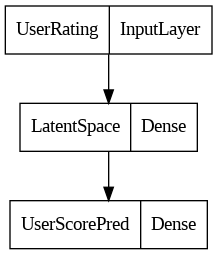

In [ ]:
plot_model(AutoRec, to_file='AutoRec.png')

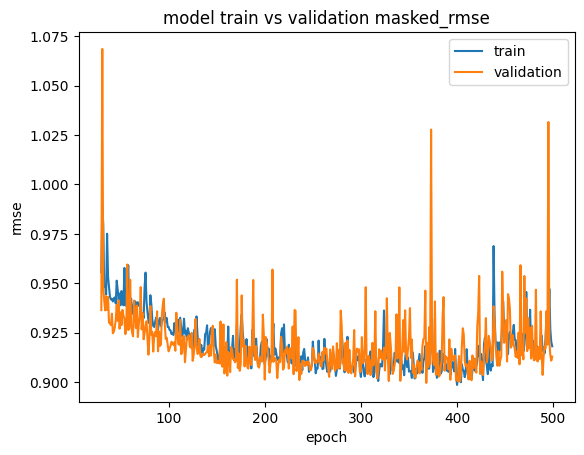

In [ ]:
show_rmse(hist_Autorec, 30)

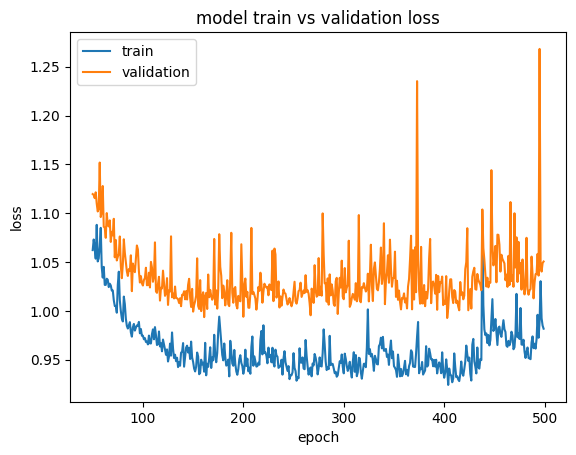

In [ ]:
show_error(hist_Autorec, 50)

In [ ]:
test_result = AutoRec.evaluate(users_items_matrix_train_average, users_items_matrix_test)

predict_autorec = AutoRec.predict(users_items_matrix_train_zero)

loss = K.eval(masked_rmse_clip( 
    K.constant((users_items_matrix_train_zero)), 
    K.constant(predict_autorec)))
np.mean(loss)
     

189/189 [==============================] - 3s 15ms/step


2.4829845

## Deep AutoEncoder

In [ ]:
 def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model
     

In [ ]:

layers = [256, 512, 256]
#layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

In [ ]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

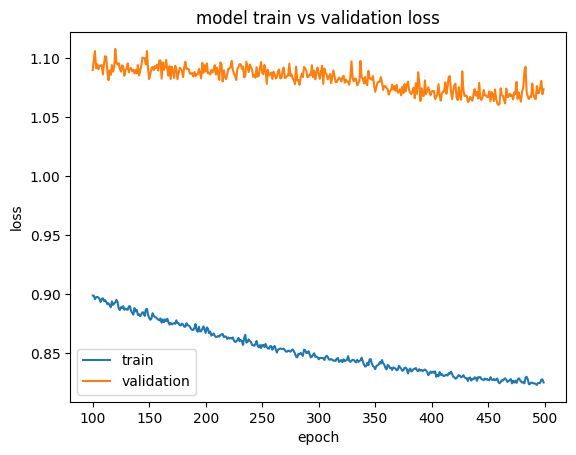

In [ ]:
show_error(hist_Deep_AE, 100)

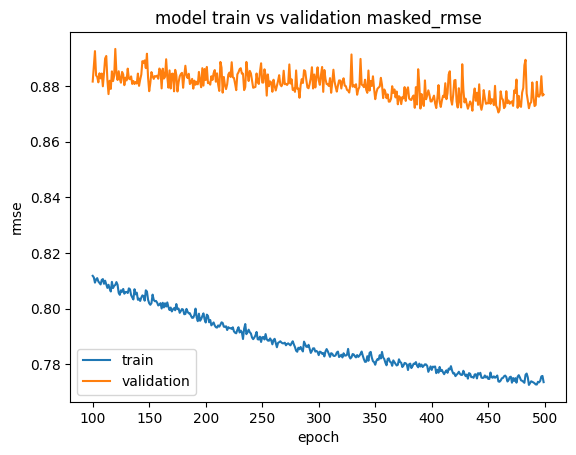

In [ ]:
show_rmse(hist_Deep_AE, 100)

In [ ]:
predict_deep = Deep_AE.predict(users_items_matrix_train_zero)

189/189 [==============================] - 2s 11ms/step


## books dataset

In [20]:
datContent = [i.strip().split() for i in open("book_ratings.dat").readlines()][1:]

In [25]:
max_user=0
max_book=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_book=max(max_book,int(r[1]))
print(max_book,max_user)

17384 2945


In [31]:
def my_proc(cont):
  matrix = np.full((max_user,max_book),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  return matrix

In [32]:
users_items_matrix_train_zero = my_proc(datContent)

In [36]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 

In [38]:
print(len(train_df),len(test_df),len(validate_df))

50751 6266 5639


In [40]:
users_items_matrix_train_zero = my_proc(train_df)
users_items_matrix_validate = my_proc(validate_df)
users_items_matrix_test = my_proc(test_df)

In [ ]:
hist_Autorec = AutoRec.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_validate, users_items_matrix_validate])

## Anime dataset

In [50]:
datContent = [i.strip().split() for i in open("anime_ratings.dat").readlines()][1:]

In [53]:
max_user=0
max_anime=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_anime=max(max_anime,int(r[1]))
print(max_user, max_anime)

5000 7390


In [55]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 
print(len(train_df),len(test_df),len(validate_df))

340153 41995 37795


In [56]:
users_items_matrix_train_zero = my_proc(train_df)
users_items_matrix_validate = my_proc(validate_df)
users_items_matrix_test = my_proc(test_df)

In [57]:
hist_Autorec = AutoRec.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=100,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_validate, users_items_matrix_validate])

Epoch 1/100
20/20 - 24s - loss: 26.1400 - masked_rmse_clip: 4.2740 - val_loss: 11.5671 - val_masked_rmse_clip: 3.0918 - 24s/epoch - 1s/step
Epoch 2/100
20/20 - 22s - loss: 5.9633 - masked_rmse_clip: 3.3473 - val_loss: 8.7735 - val_masked_rmse_clip: 2.9094 - 22s/epoch - 1s/step
Epoch 3/100
20/20 - 20s - loss: 4.2132 - masked_rmse_clip: 3.2859 - val_loss: 7.8891 - val_masked_rmse_clip: 2.8582 - 20s/epoch - 1s/step
Epoch 4/100
20/20 - 21s - loss: 3.5830 - masked_rmse_clip: 3.2699 - val_loss: 7.6133 - val_masked_rmse_clip: 2.8501 - 21s/epoch - 1s/step
Epoch 5/100
20/20 - 25s - loss: 3.2165 - masked_rmse_clip: 3.2634 - val_loss: 7.4525 - val_masked_rmse_clip: 2.8478 - 25s/epoch - 1s/step
Epoch 6/100
20/20 - 26s - loss: 2.9670 - masked_rmse_clip: 3.2603 - val_loss: 7.3739 - val_masked_rmse_clip: 2.8487 - 26s/epoch - 1s/step
Epoch 7/100
20/20 - 25s - loss: 2.7758 - masked_rmse_clip: 3.2589 - val_loss: 7.3580 - val_masked_rmse_clip: 2.8528 - 25s/epoch - 1s/step
Epoch 8/100
20/20 - 27s - loss: 

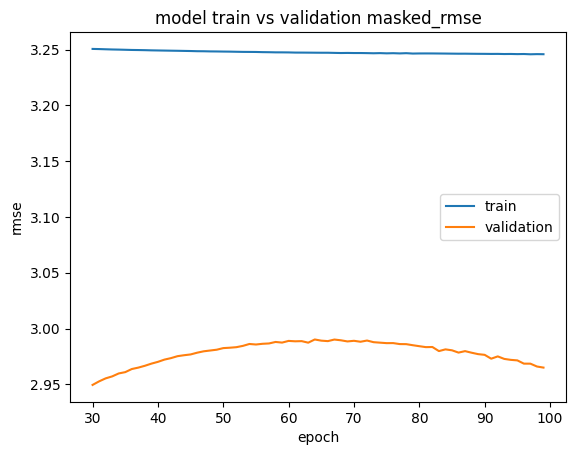

In [58]:
show_rmse(hist_Autorec, 30)